<a href="https://colab.research.google.com/github/SvetlanaSR/--/blob/master/%22INSPECTRUM_CLINIC_HR_RECSYS_GR1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSPECTRUM CLINIC HR RECSYS

В техническом задании прописаны критерии которым должны соответствовать наши модели:

1.  Система должна помогать HR-специалисту вынести решение о том, подходит или не подходит человек на рассматриваемую должность.
2.  В датасете целевым столбцом для предсказания является столбец под названием “Подходит - да/нет”.
3.  Результатом работы обученной нейросети должно служить дополнение датасета столбцом под названием “оценка резюме”, где должно быть представлено процентное распределение вероятностей между классами “подходит” и “не подходит”. Например: "подходит 95% / не подходит 5%".


In [1]:
# импортируем keras
from tensorflow import keras
from tensorflow.keras import layers

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate, ReLU, Dropout
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers.experimental import preprocessing

# Оптимизатор
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Для подключения Гугл-диска
from google.colab import drive

# Работа со временем
import time

# Чтоб рисовать в колабе:
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import pad_sequences #

# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #

#from google.colab import files #  Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления

# Запись в файлы и чтение из файлов структур данных Python
# import pickle

#import os #Для работы с файлами

# Регулярные выражения
import re

from IPython.display import clear_output

from imblearn.over_sampling import RandomOverSampler

from gensim.models import KeyedVectors  # для использования внешнего словоря частотности при подготовке текстовых данных

import tensorflow as tf

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузим как файл .xlsx
data = pd.read_excel('/content/drive/MyDrive/Базы/ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx')
data

,Unnamed: 0,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
575,578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
576,579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятос

In [ ]:
#Читаем файл
data = pd.read_excel (r'/content/drive/MyDrive/Базы/ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx', index_col=0)
#data.to_csv('DC.csv')
#data.columns = ['Response_date', 'Full_name', 'Gender', 'Salary', 'Job', 'City', 'Employment', 'Schedule', 'Experience', 'Last_place', 'Position', 'Education', 'Update_resume', 'Suitable']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Дата отклика                                579 non-null    object
 1   Пол, возраст                                579 non-null    object
 2   ЗП                                          579 non-null    object
 3   Ищет работу на должность                    579 non-null    object
 4   Город                                       579 non-null    object
 5   Занятость                                   579 non-null    object
 6   График                                      579 non-null    object
 7   Опыт ()                                     579 non-null    object
 8   Последнее/нынешное место работы             579 non-null    object
 9   Последняя/нынешняя должность                579 non-null    object
 10  Выполняемые задачи на прош

In [ ]:
duplicated_number = data.duplicated().sum()
print(duplicated_number)

0


1. Столбцы 9,10,11,15 содержат не полные данные
2.столбец 2 необходимо разбить на два

In [ ]:
list(data)

['Дата отклика',
 'Пол, возраст',
 'ЗП',
 'Ищет работу на должность',
 'Город',
 'Занятость',
 'График',
 'Опыт ()',
 'Последнее/нынешное место работы',
 'Последняя/нынешняя должность',
 'Выполняемые задачи на прошлых местах работ',
 'Обо мне',
 'Ключевые навыки',
 'Образование и ВУЗ',
 'Обновление резюме',
 'Подходит - да/нет']

In [ ]:
data.head(5)

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


In [ ]:
data.columns

Index(['Дата отклика', 'Пол, возраст', 'ЗП', 'Ищет работу на должность',
       'Город', 'Занятость', 'График', 'Опыт ()',
       'Последнее/нынешное место работы', 'Последняя/нынешняя должность',
       'Выполняемые задачи на прошлых местах работ', 'Обо мне',
       'Ключевые навыки', 'Образование и ВУЗ', 'Обновление резюме',
       'Подходит - да/нет'],
      dtype='object')

In [ ]:
# посмотрим на 'ЗП':
data['ЗП'].describe()

count            579
unique            44
top       не указана
freq             288
Name: ЗП, dtype: object

In [ ]:
# посмотрим на 'График':
data['График'].describe()

count             579
unique             30
top       полный день
freq              202
Name: График, dtype: object

In [ ]:
# посмотрим на 'Занятость':
data['Занятость'].describe()

count                  579
unique                  20
top       полная занятость
freq                   342
Name: Занятость, dtype: object

In [ ]:
# посмотрим на 'Опыт':
data['Опыт ()'].describe()

count                              579
unique                             252
top       Опыт работы —6 лет 9 месяцев
freq                                10
Name: Опыт (), dtype: object

In [ ]:
data.loc[1]

Дата отклика                                                                2023-01-11 00:00:00
Пол, возраст                                                                            Женщина
ЗП                                                                                   не указана
Ищет работу на должность                                                 Growth Product Manager
Город                                         Москва, Готова к переезду, готова к командировкам
Занятость                                                                      полная занятость
График                                             удаленная работа, гибкий график, полный день
Опыт ()                                                          Опыт работы —11 лет 11 месяцев
Последнее/нынешное место работы                                                   Банк Открытие
Последняя/нынешняя должность                        Product owner трайб сбережения и инвестиции
Выполняемые задачи на прошлых местах раб

In [ ]:
# посмотрим на 'Подходит':
data['Подходит - да/нет'].describe()

count     500
unique      2
top       нет
freq      489
Name: Подходит - да/нет, dtype: object

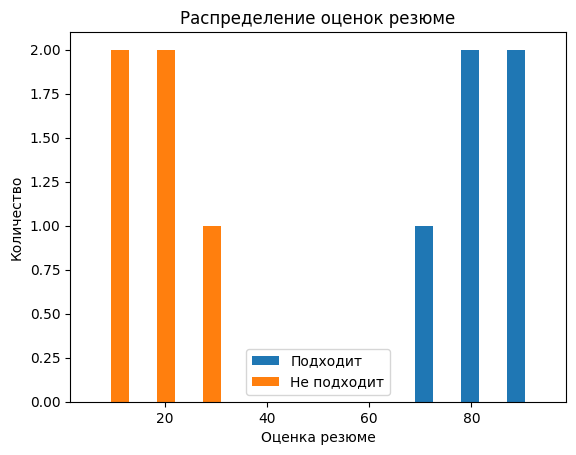

In [ ]:
# Предположим, что у вас есть массив с оценками резюме
оценки_подходит = [95, 90, 85, 80, 75]
оценки_не_подходит = [5, 10, 15, 20, 25]

# Создание гистограммы
plt.hist([оценки_подходит, оценки_не_подходит], bins=10, label=['Подходит', 'Не подходит'])
plt.xlabel('Оценка резюме')
plt.ylabel('Количество')
plt.title('Распределение оценок резюме')
plt.legend()

# Отображение графика
plt.show()

In [ ]:
data.isnull()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
578,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
579,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
580,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Дата отклика                                579 non-null    object
 1   Пол, возраст                                579 non-null    object
 2   ЗП                                          579 non-null    object
 3   Ищет работу на должность                    579 non-null    object
 4   Город                                       579 non-null    object
 5   Занятость                                   579 non-null    object
 6   График                                      579 non-null    object
 7   Опыт ()                                     579 non-null    object
 8   Последнее/нынешное место работы             579 non-null    object
 9   Последняя/нынешняя должность                579 non-null    object
 10  Выполняемые задачи на прош

In [ ]:
data.groupby('Опыт ()').count()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
Опыт (),,,,,,,,,,,,,,,
Опыт работы 10 лет 2 месяца,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
Опыт работы 16 лет 10 месяцев,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Опыт работы 17 лет 7 месяцев,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Опыт работы 3 года 9 месяцев,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Опыт работы 4 года 11 месяцев,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Опыт работы —9 лет 6 месяцев,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
Опыт работы —9 лет 7 месяцев,6,6,6,6,6,6,6,6,6,6,5,5,6,6,5
Опыт работы —9 лет 8 месяцев,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3


In [ ]:
data.groupby('ЗП').count()

,Дата отклика,"Пол, возраст",Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
ЗП,,,,,,,,,,,,,,,
1 200 EUR,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1 550 USD,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1 900 000 KZT,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
1 руб.,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
100 000 KGS,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
100 000 руб.,24,24,24,24,24,24,24,24,24,23,18,22,24,24,20
110 000 руб.,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3
119 000 руб.,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
120 000 руб.,15,15,15,15,15,15,15,15,15,13,10,13,15,15,12


In [ ]:
data.groupby('Занятость').count()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
Занятость,,,,,,,,,,,,,,,
полная занятость,342,342,342,342,342,342,342,342,342,328,246,314,342,342,300
"полная занятость, проектная работа",8,8,8,8,8,8,8,8,8,8,8,8,8,8,7
"полная занятость, стажировка",1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
"полная занятость, частичная занятость",22,22,22,22,22,22,22,22,22,22,19,19,22,22,22
"полная занятость, частичная занятость, проектная работа",14,14,14,14,14,14,14,14,14,13,9,13,14,14,11
"полная занятость, частичная занятость, проектная работа, волонтерство",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"полная занятость, частичная занятость, проектная работа, стажировка",4,4,4,4,4,4,4,4,4,4,4,4,4,4,1
проектная работа,2,2,2,2,2,2,2,2,2,1,1,1,2,2,0
"проектная работа, волонтерство, частичная занятость, полная занятость",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
data.groupby('Подходит - да/нет').count()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме
Подходит - да/нет,,,,,,,,,,,,,,,
да,11,11,11,11,11,11,11,11,11,11,10,6,10,11,11
нет,489,489,489,489,489,489,489,489,489,489,467,371,448,489,489


In [ ]:
# посмотрим на столбец "Пол, возраст"
data["Пол, возраст"].value_counts()

Женщина                                       41
Мужчина                                       35
Женщина, 37 лет, родилась 3 января 1986        4
Мужчина, 28 лет, родился 16 августа 1994       4
Мужчина, 21 год, родился 8 марта 2001          3
                                              ..
Женщина, 26 лет, родилась 25 сентября 1996     1
Женщина, 22 года, родилась 17 июля 2000        1
Мужчина, 26 лет, родился 18 апреля 1996        1
Женщина, 27 лет, родилась 11 декабря 1995      1
Женщина, 29 лет, родилась 21 марта 1993        1
Name: Пол, возраст, Length: 443, dtype: int64

In [ ]:
# посмотрим на столбец "Опыт"
data["Опыт ()"].value_counts()

Опыт работы —6 лет 9 месяцев      10
Опыт работы —7 лет 2 месяца        9
Опыт работы —8 лет 6 месяцев       8
Опыт работы —9 лет 3 месяца        8
Опыт работы —3 года 9 месяцев      7
                                  ..
Опыт работы —25 лет 9 месяцев      1
Опыт работы —9 лет 5 месяцев       1
Опыт работы —17 лет 10 месяцев     1
Опыт работы —28 лет 11 месяцев     1
Опыт работы —15 лет 9 месяцев      1
Name: Опыт (), Length: 252, dtype: int64

In [ ]:
# посмотрим на столбец "ЗП"
data["ЗП"].value_counts()

не указана       288
50 000 руб.       27
100 000 руб.      24
70 000 руб.       24
40 000 руб.       23
150 000 руб.      21
60 000 руб.       21
30 000 руб.       20
35 000 руб.       19
80 000 руб.       18
120 000 руб.      15
200 000 руб.       8
45 000 руб.        8
90 000 руб.        7
75 000 руб         5
180 000 руб.       4
110 000 руб.       4
95 000 руб.        3
55 000 руб.        3
85 000 руб.        3
20 000 руб.        3
65 000 руб.        2
1 550 USD          2
130 000 руб.       2
280 000 руб.       2
250 000 руб.       2
1 руб.             2
25 000 руб.        2
2 000 USD          2
100 000 KGS        1
155 000 руб.       1
170 000 руб.       1
3 500 USD          1
600 000 KZT        1
160 000 руб.       1
127 000 руб.       1
119 000 руб.       1
350 000 руб.       1
4 000 USD          1
2 500 USD          1
1 200 EUR          1
1 900 000 KZT      1
140 000 руб.       1
3 000 USD          1
Name: ЗП, dtype: int64

In [ ]:
# посмотрим на столбец "Занятость"
data["Занятость"].value_counts()

полная занятость                                                                     342
проектная работа, частичная занятость, полная занятость                              101
проектная работа, полная занятость                                                    34
полная занятость, частичная занятость                                                 22
частичная занятость, полная занятость                                                 15
полная занятость, частичная занятость, проектная работа                               14
проектная работа, стажировка, частичная занятость, полная занятость                   12
проектная работа, стажировка, волонтерство, частичная занятость, полная занятость     11
полная занятость, проектная работа                                                     8
полная занятость, частичная занятость, проектная работа, стажировка                    4
частичная занятость                                                                    4
проектная работа, час

In [ ]:
# рассмотрим содержимое колонки "Занятость"
data["Занятость"].unique()

array(['проектная работа, частичная занятость, полная занятость',
       'полная занятость',
       'стажировка, частичная занятость, полная занятость',
       'полная занятость, частичная занятость, проектная работа',
       'проектная работа, полная занятость',
       'проектная работа, стажировка, волонтерство, частичная занятость, полная занятость',
       'проектная работа, стажировка, частичная занятость, полная занятость',
       'частичная занятость, полная занятость',
       'проектная работа, стажировка, полная занятость',
       'стажировка, полная занятость', 'частичная занятость',
       'проектная работа, неполный рабочий день, полный рабочий день',
       'проектная работа, частичная занятость',
       'полная занятость, частичная занятость, проектная работа, стажировка',
       'проектная работа, волонтерство, частичная занятость, полная занятость',
       'полная занятость, проектная работа',
       'полная занятость, частичная занятость',
       'полная занятость, час

In [ ]:
# посмотрим на столбец "Образование и ВУЗ"
data["Образование и ВУЗ"].value_counts()

Среднее образование                                                                                                  15
Высшее, 2016, Башкирская академия государственной службы и управления при Президенте Республики Башкортостан, Уфа     4
Высшее, 2012, Уфимский государственный авиационный технический университет, Уфа                                       3
Высшее, 2009, СПГБПУ                                                                                                  3
Высшее, 2013, Уральский федеральный университет имени первого Президента России Б.Н. Ельцина, Екатеринбург            3
                                                                                                                     ..
Высшее, 2016, Уфимский государственный авиационный технический университет, Уфа                                       1
Среднее специальное, 2012, ЯУК                                                                                        1
Магистр, 2015, Армянский Государственный

In [ ]:
np=data.isnull().sum()

In [ ]:
np

Дата отклика                                    0
Пол, возраст                                    0
ЗП                                              0
Ищет работу на должность                        0
Город                                           0
Занятость                                       0
График                                          0
Опыт ()                                         0
Последнее/нынешное место работы                 0
Последняя/нынешняя должность                    0
Выполняемые задачи на прошлых местах работ     27
Обо мне                                       135
Ключевые навыки                                47
Образование и ВУЗ                               0
Обновление резюме                               0
Подходит - да/нет                              79
dtype: int64

In [ ]:
data.describe(include=['O'])

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
count,579,579,579,579,579,579,579,579,579,579,552,444,532,579,579,500
unique,89,443,44,8,209,20,30,252,486,358,548,418,479,488,547,2
top,2023-02-22 00:00:00,Женщина,не указана,Growth Product Manager,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —6 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product manager,Управлял тремя отдельными блокчейн-проектами с...,"Стрессоустойчивый, энергичный, нацелен на резу...",Обучаемость,Среднее образование,31 января 2023 в 09:52,нет
freq,48,41,288,198,69,342,202,10,12,42,2,3,9,15,3,489


In [ ]:
data["Город"].value_counts()

Уфа, Не готова к переезду, не готова к командировкам                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              69
Уфа, Не готова к переезду, готова к редким командировкам                                           

Выводы:
1. предлагаю выделить в три отдельных атрибута:
 - до первой запятой: текстовый "Город"  и затем категоризировать: (город работодателя (Москва), Миллионники, Зарубеж, остальные)
 - от первой до посдедней запятой: булево "готов к переезду", где 1 принадлежит вариациям "готов к переезду" без конкретики ИЛИ
   "готов к переезду" + город/страна Работодателя;  0 == все остальное
 - после последней запятой: 3 категории "готов к командировкам": (нет, редкие, да)

In [ ]:
# рассмотрим содержимое колонки соискателя должности
data["Ищет работу на должность"].unique()

array(['Growth Product Manager',
       'Product manager в Growth Hacking команду',
       'Директор медицинской клиники', 'HR-специалист',
       'Product Manager в команду Финансового департамента',
       'Product Manager в команду HR', 'Project manager',
       'Product Marketing Manager в Growth Hacking команду'], dtype=object)

In [ ]:
def convertDataSet(data):
          #Если необходимо переименовать
          data.columns = ['Response date','Gender_age','PO','Looking for a job for a position','City','Employment','Schedule','Experience ()','Last/current job','Last/current position','Tasks performed at previous jobs','About me','Key Skills','Education and University','Resume update','Suitable - yes/no']

In [ ]:
#data[['Gender','age']] = data.Gender_age.str.split(",",expand=True)

In [ ]:
convertDataSet(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Response date                     579 non-null    object
 1   Gender_age                        579 non-null    object
 2   PO                                579 non-null    object
 3   Looking for a job for a position  579 non-null    object
 4   City                              579 non-null    object
 5   Employment                        579 non-null    object
 6   Schedule                          579 non-null    object
 7   Experience ()                     579 non-null    object
 8   Last/current job                  579 non-null    object
 9   Last/current position             579 non-null    object
 10  Tasks performed at previous jobs  552 non-null    object
 11  About me                          444 non-null    object
 12  Key Skills            

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус"

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Response date                     579 non-null    object
 1   Gender_age                        579 non-null    object
 2   PO                                579 non-null    object
 3   Looking for a job for a position  579 non-null    object
 4   City                              579 non-null    object
 5   Employment                        579 non-null    object
 6   Schedule                          579 non-null    object
 7   Experience ()                     579 non-null    object
 8   Last/current job                  579 non-null    object
 9   Last/current position             579 non-null    object
 10  Tasks performed at previous jobs  552 non-null    object
 11  About me                          444 non-null    object
 12  Key Skills            

In [ ]:
def convertDataSet(data):
          #Разбираем Возраст
          Age = data['Gender_age'].apply(lambda x: x.split(',')[1].strip() if len(x.split(','))>1 else '')
          data = data.assign(Age=Age)

In [ ]:
convertDataSet(data)

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус"

In [ ]:
def convertDataSet(data):
          #Тип образования
          DegreeOfStudy = data['Education and University'].apply(lambda x: x.split(',')[0].strip() if len(x.split(','))>1 else '')
          data = data.assign(DegreeOfStudy=DegreeOfStudy)

In [ ]:
convertDataSet(data)

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус"

In [ ]:
def convertDataSet(data):
          #Тип образования
          DegreeOfStudy = data['Education and University'].apply(lambda x: x.split(',')[0].strip() if len(x.split(','))>1 else '')
          data = data.assign(DegreeOfStudy=DegreeOfStudy)

In [ ]:
convertDataSet(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Response date                     579 non-null    object
 1   Gender_age                        579 non-null    object
 2   PO                                579 non-null    object
 3   Looking for a job for a position  579 non-null    object
 4   City                              579 non-null    object
 5   Employment                        579 non-null    object
 6   Schedule                          579 non-null    object
 7   Experience ()                     579 non-null    object
 8   Last/current job                  579 non-null    object
 9   Last/current position             579 non-null    object
 10  Tasks performed at previous jobs  552 non-null    object
 11  About me                          444 non-null    object
 12  Key Skills            

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус"

In [ ]:
def convertDataSet(data):
          #Тип образования
          DegreeOfStudy = data['Education and University'].apply(lambda x: x.split(',')[0].strip() if len(x.split(','))>1 else '')
          data = data.assign(DegreeOfStudy=DegreeOfStudy)
          #Год окончания образования
          YearOfGraduation = data['Education and University'].apply(lambda x: x.split(',')[1].strip() if len(x.split(','))>1 else '')
          data = data.assign(YearOfGraduation=YearOfGraduation)

In [ ]:
convertDataSet(data)

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус"

In [ ]:
def convertDataSet(data):
          #Формируем список месяцев
          month_name = {1: 'января', 2: 'февраля', 3: 'марта', 4: 'апреля', 5: 'мая', 6: 'июня',
                7: 'июля', 8: 'августа', 9: 'сентября', 10: 'октября', 11: 'ноября', 12: 'декабря'}

In [ ]:
convertDataSet(data)

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус"

In [ ]:
def convertDataSet(data):
            #Birth
                row.Gender_age = row.Gender_age.replace('родился','')
                row.Gender_age = row.Gender_age.replace('родилась','')

In [ ]:
def convertDataSet(data):
            for i, row in data.iterrows():
            #Gender
                row.Gender_age = row.Gender_age.split(',')[0].strip()
            #Женщина = 0, Мужчина = 1
                row.Gender_age = row.Gender_age.replace('Женщина','0')
                row.Gender_age = row.Gender_age.replace('Мужчина','1')
                row.Gender_age = int(row.Gender_age)

In [ ]:
convertDataSet(data)

In [ ]:
data

,Response date,Gender_age,PO,Looking for a job for a position,City,Employment,Schedule,Experience (),Last/current job,Last/current position,Tasks performed at previous jobs,About me,Key Skills,Education and University,Resume update,Suitable - yes/no
0,2023-02-23 00:00:00,0,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,0,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,1,150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,1,не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,1,150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,1,70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,1,100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,1,80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус""","Территориальный менеджер (Уфа, Пермь, Ижевск, ...",развитие продаж на территории (развитие продаж...,"Коммуникабельность, нацеленность на результат,...",Работоспособность,"Высшее, 2005, Стерлитамакская государственная ...",6 июля 2022 в 15:05,NaN
580,

# **Парсим базу**

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  #Если М, то 1. По умолчанию 0 - Ж
  if "М" in arg:
    out[0] = 1
  # текущий год - год рождения
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')

        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()

        # Конвертируем в рубли, если валюта
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5

    salaryStr = int(num)


    return salaryStr


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] #По умолчанию не указано
  if "Высшее" in arg or "Higher education" in arg:  out[0] = 1
  if "Среднее специальное" in arg:      out[1] = 1
  if "Неоконченное высшее" in arg:      out[2] = 1
  if "Среднее образование" in arg:      out[3] = 1
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1

  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)

         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)

  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9
  if (out > 240): # если больше 240 месяцев
    outClass = 10

  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  #getParameterSex() #параметры о поле
  age =getParameterAgeVect(result[1]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = []

# Склеиваем все параметры в вектор
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience

  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []

  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    x = getAllParameters(val)
    xTrain.append(x)
    yTrain.append(y/1000)

  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)


  return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

NameError: ignored

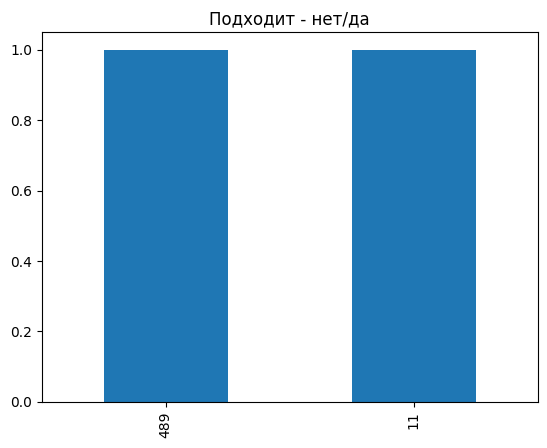

In [ ]:
#Смотрим на распределение признаков Подходит - да/нет
countsSuitable = data['Suitable - yes/no'].value_counts()
countsSuitable.value_counts().plot(kind='bar', label='Suitable')
plt.title('Подходит - нет/да')
plt.show()

In [ ]:
#Формируем список месяцев
month_name = {1: 'января', 2: 'февраля', 3: 'марта', 4: 'апреля', 5: 'мая', 6: 'июня',
      7: 'июля', 8: 'августа', 9: 'сентября', 10: 'октября', 11: 'ноября', 12: 'декабря'}


In [ ]:
for i, row in data.iterrows():
  #Gender
  row.Gender_age = row.Gender_age.split(',')[0].strip()
  #Женщина = 0, Мужчина = 1
  row.Gender = row.Gender.replace('Женщина','0')
  row.Gender = row.Gender.replace('Мужчина','1')
  row.Gender = int(row.Gender)

  #Birth
  row.Birth = row.Birth.replace('родился','')
  row.Birth = row.Birth.replace('родилась','')

  #Age
  row.Age = row.Age.replace('года','')
  row.Age = row.Age.replace('год','')
  row.Age = row.Age.replace('лет','')
  row.Age = row.Age='' if 0 else row.Age

  try:
    row.Age = int(row.Age)
  except (IndexError, TypeError, ValueError):
    print(row.Age)
    row.Age = 0

  #Salary
  row.Salary = row.Salary.replace(' ','')
  row.Salary = str(float(row.Salary.replace('KGS',''))*0.89)      if row.Salary.find('KGS') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('KZT',''))*0.18)      if row.Salary.find('KZT') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('USD',''))*78.00)     if row.Salary.find('USD') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('EUR',''))*85.00)     if row.Salary.find('EUR') != -1 else row.Salary
  row.Salary = row.Salary.replace('руб.','')
  row.Salary = row.Salary.replace('руб','')
  row.Salary = row.Salary.replace('неуказана','0')
  row.Salary = int(float(row.Salary))

  #Experience
  row.Experience = row.Experience.replace('Опыт работы —','')
  row.Experience = row.Experience.replace('Опыт работы','')
  row.Experience = row.Experience.replace('года',';')
  row.Experience = row.Experience.replace('лет',';')
  row.Experience = row.Experience.replace('годов',';')
  row.Experience = row.Experience.replace('год',';')
  row.Experience = row.Experience.replace('года',';')
  row.Experience = row.Experience.replace('месяцев','')
  row.Experience = row.Experience.replace('месяца','')
  row.Experience = row.Experience.replace('месяц','')
  row.Experience = row.Experience.replace('нет','0')
  #Приводим к месяцам, если были года умножаем на 12 иначе берем как есть
  row.Experience = (int(row.Experience.split(';')[0].strip()) * 12 + (int(row.Experience.split(';')[1].strip())) if row.Experience.split(';')[1].strip() != '' else int(row.Experience.split(';')[0].strip()) * 12) if len(row.Experience.split(';')) >1 else int(row.Experience.strip())

  #Schedule
  #вахтовый метод = 0, удаленная работа = 1, гибкий график = 2, полный день = 3, сменный график = 4
  row.Schedule = row.Schedule.replace('вахтовый метод','0')
  row.Schedule = row.Schedule.replace('удаленная работа','1')
  row.Schedule = row.Schedule.replace('гибкий график','2')
  row.Schedule = row.Schedule.replace('полный день','3')
  row.Schedule = row.Schedule.replace('сменный график','4')

  #Employment
  #проектная работа = 0, неполный рабочий день = 1, полный рабочий день = 2, полная занятость = 3, частичная занятость = 4, стажировка = 5, волонтерство = 6
  row.Employment = row.Employment.replace('проектная работа','0')
  row.Employment = row.Employment.replace('неполный рабочий день','1')
  row.Employment = row.Employment.replace('полный рабочий день','2')
  row.Employment = row.Employment.replace('полная занятость','3')
  row.Employment = row.Employment.replace('частичная занятость','4')
  row.Employment = row.Employment.replace('стажировка','5')
  row.Employment = row.Employment.replace('волонтерство','6')

  #Birth
  for i in month_name:
     row.Birth         = row.Birth.replace(month_name[i],'-'+str(i)+'-')

  row.Birth         = row.Birth.replace('родился','')
  row.Birth         = row.Birth.replace('родилась','')
  row.Birth         = row.Birth.replace(' -','-')
  row.Birth         = row.Birth.replace('- ','-')
  row.Birth         = row.Birth+' 00:00:00'

  row.Birth = '1-1-1' +row.Birth if row.Birth == ' 00:00:00' else row.Birth
  day = int(row.Birth.split('-')[0].strip())
  month = int(row.Birth.split('-')[1].strip())
  year = row.Birth.split('-')[2].strip()
  time = year.split(' ')[1].strip()
  year = int(year.split(' ')[0].strip())

  row.Birth = int(datetime.datetime(year,month,day).utcnow().timestamp())

  #Update_resume
  for i in month_name:
    row.Update_resume = row.Update_resume.replace(month_name[i],'-'+str(i)+'-')

  row.Update_resume = row.Update_resume.replace('в','')
  row.Update_resume = row.Update_resume.replace(' -','-')
  row.Update_resume = row.Update_resume.replace('- ','-')
  row.Update_resume = row.Update_resume+':00'

  day = int(row.Update_resume.split('-')[0].strip())
  month = int(row.Update_resume.split('-')[1].strip())
  year = row.Update_resume.split('-')[2].strip()
  year = year.replace('  ',';')
  year = year.replace(' ',';')

  time = year.split(';')[1].strip()
  year = int(year.split(';')[0].strip())
  hour = int(time.split(':')[0].strip())
  minute = int(time.split(':')[1].strip())

  row.Update_resume = int(datetime.datetime(year,month,day,hour,minute,0).utcnow().timestamp())

  #Response_date
  row.Response_date = int(datetime.datetime.utcnow().timestamp())

AttributeError: ignored

In [ ]:
#Переведем в бинарные значения

#проектная работа = 0, неполный рабочий день = 1, полный рабочий день = 2, полная занятость = 3, частичная занятость = 4, стажировка = 5, волонтерство = 6
Employment_0 = data['Employment'].apply(lambda x: 1 if x.find('0') else 0)
Employment_1 = data['Employment'].apply(lambda x: 1 if x.find('1') else 0)
Employment_2 = data['Employment'].apply(lambda x: 1 if x.find('2') else 0)
Employment_3 = data['Employment'].apply(lambda x: 1 if x.find('3') else 0)
Employment_4 = data['Employment'].apply(lambda x: 1 if x.find('4') else 0)
Employment_5 = data['Employment'].apply(lambda x: 1 if x.find('5') else 0)
Employment_6 = data['Employment'].apply(lambda x: 1 if x.find('6') else 0)

data = data.assign(Employment_0=Employment_0,
                    Employment_1=Employment_1,
                    Employment_2=Employment_2,
                    Employment_3=Employment_3,
                    Employment_4=Employment_4,
                    Employment_5=Employment_5,
                    Employment_6=Employment_6)

#вахтовый метод = 0, удаленная работа = 1, гибкий график = 2, полный день = 3, сменный график = 4
Schedule_0 = data['Schedule'].apply(lambda x: 1 if x.find('0') else 0)
Schedule_1 = data['Schedule'].apply(lambda x: 1 if x.find('1') else 0)
Schedule_2 = data['Schedule'].apply(lambda x: 1 if x.find('2') else 0)
Schedule_3 = data['Schedule'].apply(lambda x: 1 if x.find('3') else 0)
Schedule_4 = data['Schedule'].apply(lambda x: 1 if x.find('4') else 0)

data = data.assign(Schedule_0=Schedule_0,
                    Schedule_1=Schedule_1,
                    Schedule_2=Schedule_2,
                    Schedule_3=Schedule_3,
                    Schedule_4=Schedule_4)

data = data.drop(columns=['Schedule', 'Employment'])

In [ ]:
#City
tokenizer = Tokenizer(num_words=30, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.City) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
City_Indexes = tokenizer.texts_to_sequences(data.City)
data = data.assign(City=City_Indexes)

In [ ]:
#Full_name
tokenizer = Tokenizer(num_words=100, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Full_name)

Full_name_Indexes = tokenizer.texts_to_sequences(data.Full_name)
data = data.assign(Full_name=Full_name_Indexes)

AttributeError: ignored

In [ ]:
#Education
tokenizer = Tokenizer(num_words=200, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Education) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Education_Indexes = tokenizer.texts_to_sequences(data.Education)
data = data.assign(Education=Education_Indexes)

AttributeError: ignored

In [ ]:
#Job
tokenizer = Tokenizer(num_words=150, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Job) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Job_Indexes = tokenizer.texts_to_sequences(data.Job)
data = data.assign(Job=Job_Indexes)

AttributeError: ignored

In [ ]:
#Last_place
tokenizer = Tokenizer(num_words=150, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Last_place) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Last_place_Indexes = tokenizer.texts_to_sequences(data.Last_place)
data = data.assign(Last_place=Last_place_Indexes)

AttributeError: ignored

In [ ]:
#Position
tokenizer = Tokenizer(num_words=150, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Position) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Position_Indexes = tokenizer.texts_to_sequences(data.Position)
data = data.assign(Position=Position_Indexes)

AttributeError: ignored

In [ ]:
#Suitable
#Список ответов делаем
listAnswers = []
#Обработаем отдельно колонку с ответами
for i, row in data.iterrows():
   a = 1 if str(row.Suitable).find('да') != -1 else 0
   listAnswers.append([a])
answers = np.array(listAnswers)
print(answers.shape)

(579, 1)


In [ ]:
data = data.drop(columns=['Suitable'])

In [ ]:
data.info()

In [ ]:
#Приведим все списки к однообразию
data.Response_date = data.Response_date.astype('int')
data.Gender = data.Gender.astype('int')
data.Salary = data.Salary.astype('int')
data.Update_resume = data.Update_resume.astype('int')
data.Birth = data.Birth.astype('int')
data.Age = data.Age.astype('int')

#Находим максимальную длину
Full_nameMaxI = 0
PositionMaxI = 0
Last_placeMaxI = 0
JobMaxI = 0
EducationMaxI = 0
CityMaxI = 0
for i, row in data.iterrows():
    Full_nameMaxI   = max(Full_nameMaxI,len(row.Full_name))
    PositionMaxI    = max(PositionMaxI,len(row.Position))
    Last_placeMaxI  = max(Last_placeMaxI,len(row.Last_place))
    JobMaxI         = max(JobMaxI,len(row.Job))
    EducationMaxI   = max(EducationMaxI,len(row.Education))
    CityMaxI        = max(CityMaxI,len(row.City))


In [ ]:
#обрабатываем данные list
dataList = []
for i, row in data.iterrows():
      row.Full_name     = np.array(row.Full_name+[0 for x in range(Full_nameMaxI-len(row.Full_name))])
      row.Position      = np.array(row.Position+[0 for x in range(PositionMaxI-len(row.Position))])
      row.Last_place    = np.array(row.Last_place+[0 for x in range(Last_placeMaxI-len(row.Last_place))])
      row.Job           = np.array(row.Job+[0 for x in range(JobMaxI-len(row.Job))])
      row.Education     = np.array(row.Education+[0 for x in range(EducationMaxI-len(row.Education))])
      row.City          = np.array(row.City+[0 for x in range(CityMaxI-len(row.City))])

      #row_data = np.hstack(row)
      row_data = np.hstack([
                            row.Full_name,
                            row.Position,
                            row.Last_place,
                            row.Job,
                            row.Education,
                            row.City,
                            row.Response_date,
                            row.Gender,
                            row.Salary,
                            row.Update_resume,
                            row.Birth,
                            row.Age,
                            row.Employment_0,
                            row.Employment_1,
                            row.Employment_2,
                            row.Employment_3,
                            row.Employment_4,
                            row.Employment_5,
                            row.Employment_6,
                            row.Schedule_0,
                            row.Schedule_1,
                            row.Schedule_2,
                            row.Schedule_3,
                            row.Schedule_4]
                          )

      dataList.append(row_data)

dataset = np.array(dataList) #, dtype=np.float
print(dataset.shape)

(579, 213)


In [ ]:
data.info()

In [ ]:
#Смотрим что получилось
data.max_columns = 30
data.head(-15)

In [ ]:
for row in dataset:
    print(dataset)

In [ ]:
# Делаем выборки для обучения
x_train, x_test, y_train, y_test = train_test_split(dataset, # набор параметров
                                                    answers, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

In [ ]:
x_train.shape

(463, 213)

In [ ]:
# Оптимизаторы
from tensorflow.keras.optimizers import Adam
# Основные слои
from tensorflow.keras.layers import ReLU, Flatten

# Создание последовательной модели
model = Sequential()
model.add(Dense(60, activation='relu',input_dim=x_train.shape[1]))
model.add(Activation('relu'))
#model.add(BatchNormalization())
#model.add(BatchNormalization(input_dim=x_train.shape[1]))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(30, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Flatten())
#model.add(Dense(30, activation='softmax'))
#model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) #softmax linear

# Компиляция модели
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

#model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

# Обучение сети
history = model.fit(x_train,
                    y_train, #y_train
                    batch_size=8,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
47/47 [==============================] - 3s 8ms/step - loss: 0.1235 - accuracy: 0.9622 - val_loss: 0.1992 - val_accuracy: 0.9570
Epoch 2/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0885 - accuracy: 0.9838 - val_loss: 0.1837 - val_accuracy: 0.9570
Epoch 3/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0885 - accuracy: 0.9838 - val_loss: 0.1826 - val_accuracy: 0.9570
Epoch 4/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.9838 - val_loss: 0.1848 - val_accuracy: 0.9570
Epoch 5/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0911 - accuracy: 0.9838 - val_loss: 0.1807 - val_accuracy: 0.9570
Epoch 6/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0870 - accuracy: 0.9838 - val_loss: 0.2351 - val_accuracy: 0.9570
Epoch 7/10
47/47 [==============================] - 0s 6ms/step - loss: 0.0886 - accuracy: 0.9838 - val_loss: 0.2210 - val_accuracy: 0.9570
Epoch 8/10
47/47 [==

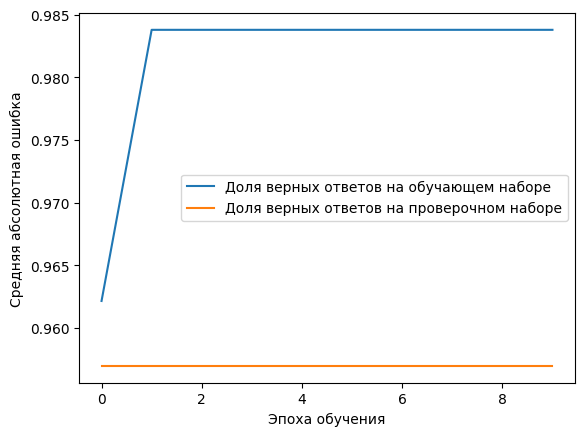

In [ ]:
# Визуализация точности на обучающей выборке
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе') #mae
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе') #val_mae
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Проверка работы сети - предсказание на тренировочной выборке
pred = model.predict(x_train)

# Расчет среднего значения ошибки
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

15/15 [==============================] - 0s 2ms/step
0.03225162461778193
0.03225162461778193
